In [1]:
import pickle
import numpy as np
import sys
import os
import pandas as pd

from matplotlib import pyplot as plt

import glob

sys.path.append('/Users/taylorcarter/Desktop/Observation.py')

from Observation import Observation

In [2]:
herd_hover_data_folder = '/Users/taylorcarter/Desktop' 

observation_files = glob.glob(
    herd_hover_data_folder + 
    '/observation*-processed.pkl'
)

observation_files.sort()

In [3]:
observations = []
for file in observation_files[:]:
    with open(file, 'rb') as f:
        observation = pickle.load(f)
        observations.append(observation)

In [4]:
for ind, obs in enumerate(observations):
    print(ind, obs.name)

0 observation015
1 observation027


In [5]:
positions = [observation.positions for observation in observations]
postures = [observation.postures for observation in observations]
posture_scores = [observation.posture_scores for observation in observations]

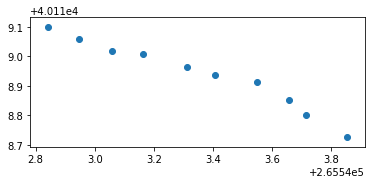

In [6]:
# Using tracks

observation_index = 0
track_num = 1
plt.scatter(positions[observation_index][track_num][0:10, 0],
            positions[observation_index][track_num][0:10, 1])
plt.gca().set_aspect('equal', adjustable='box')

In [7]:
def closest_ind(pts_act):
    """
    Generates relative and actual x,y positions of closest individual relative to each individual within 
    a given 3d numpy array.
    
    Inputs:
        pts_act: 3d numpy array with raw xy positions of animals in space with shape (individual, frame, 2)
    Output:
        coords_rel: 3d numpy array with x,y positions of animals in pts_act relative to the focal
                    individual. Has same shape as current array in pts_act (individuals, frames, 2)
        coords_act: 3d numpy array with x,y positions of animals in pts_act that coorespond to coords_rel
                    Has same shape as current array in pts_act (individuals, frames, 2)
    
    """
    coords_rel = np.zeros(pts_act.shape)
    coords_act = np.zeros(pts_act.shape)
    
    for indv in range(pts_act.shape[0]):
        diff = pts_act - pts_act[indv]
        dis = np.sqrt((diff[:,:,0])**2 + (diff[:,:,1])**2)

        m = np.argmin(np.where(dis==0, dis.max(), dis), axis=0)

        rel_loc = np.zeros(diff[0].shape)
        act_loc = np.zeros(diff[0].shape)

        for i in range(m.shape[0]):
            rl = diff[m[i], i, :]
            rel_loc[i,:] = rl

            al = diff[m[i], i, :]
            act_loc[i,:] = al

        coords_rel[indv,:,:] = rel_loc
        coords_act[indv,:,:] = act_loc
            
    return coords_rel, coords_act

In [8]:
def sim_walk(pts_act):
    """
    Generates x,y positions for every individual in a data set by pulling random values from calculated step 
    sizes and turning angles
    
    Inputs:
        pts_act: 3d numpy array with raw xy positions of animals in space with shape (individual, frame, 2)
    Ouputs:
        walk: 3d numpy array with new xy positions of animals in pts_act
        
    """
    act_diff = np.diff(pts_act, axis=1)
    step_size = np.sqrt((act_diff[:,:,0])**2 + (act_diff[:,:,1])**2)
    act_dir = np.arctan2(act_diff[:,:,1], act_diff[:,:,0])
    d_diff = np.diff(act_dir)
    
    coords = np.zeros(pts_act.shape)
    
    for ind in range(pts_act.shape[0]):
        
        random_step = np.random.choice(step_size[ind], len(pts_act[ind]))
        random_turn = np.random.choice(d_diff[ind], len(pts_act[ind]))
 
        x = random_step * (np.cos(random_turn))
        y = random_step * (np.sin(random_turn))

        coords[ind, :, 0] = x
        coords[ind, :, 1] = y
        coords[ind, 0] = coords[ind,0] + pts_act[ind,0]

        walk = np.cumsum(coords, axis=1)
    return walk

In [9]:
def group_center(pts_act, number_ind=None, subset=False):
    """
    Generates x,y positions for the center of the whole group or the center of k number of closest individuals
    relative to each individual in the dataset
    
    Inputs:
        pts_act: 3d numpy array with raw xy positions of animals in space with shape (individual, frame, 2)
        subset: if True, finds center of k number of closest individuals (number_ind) relative to focal
                individual
        number_ind: int 2 or above. Designates number of closest individuals to consider
    Output:
        c_diff: 3d numpy array with x,y positions of the center of the group relative to every individual
                in every frame. Has shape (individuals, frames, 2)
        If subset==True:
            c_diff: 3d numpy array with x,y positions of the center of the k number of closest individuals
                    relative to focal individual. Has shape (individuals, frames, 2)
            center: 3d numpy array with x,y positions of the center of the k number of closest individuals.
                    Has shape (individuals, frames, 2)
    
    """
    center = np.zeros(pts_act.shape)
    
    if subset==True:
        for ind in range(pts_act.shape[0]):
            diff = pts_act - pts_act[ind]
            dis = np.sqrt((diff[:,:,0])**2 + (diff[:,:,1])**2)
            
            sort = np.argsort(np.where(dis==0, dis.max(), dis), axis=0)
            sort = sort[0:number_ind, :]
            
            if number_ind<2 or number_ind>=pts_act.shape[0]:
                raise ValueError("ValueError: number of individuals needs to be between 2 and pts_act.shape[0]" 
                                 + str(len(pts_act)-1))

            act_loc = np.zeros((sort.shape[0], sort.shape[1]), 2)
            
            for i in range(sort.shape[0]):
                for pt in range(sort.shape[1]):
                    al = pts_act[sort[i, pt], pt]
                    act_loc[i, pt ,:] = al
        
            center[ind, :, :] = np.nanmean(act_loc, axis=0)

    else:
        center[:,:,:] = np.nanmean(pts_act, axis=0)
        
    c_diff = center - pts_act
    
    return c_diff, center

In [10]:
def gen_infl_points(pts_act, pts_inf_rel, w):
    """
    Generates new xy positions of animals in pts_act that take into acount some degree of social influence (w)
    
    Inputs:
        pts_act: 3d numpy array with raw xy positions of animals in space with shape (individual, frame, 2)
        pts_inf: 3d numpy array with xy positions of social influencer relative 
                 to location of animals in pts_act with shape (individual, frame, 2)
        w: weight of social influence (range: 0-1)
    
    Output:
        coords: 3d numpy array with new xy positions of animals in pts_act that take into acount some 
                degree of social influence (w). Has shape (individual, frame - 1, 2)
    """
    coords = np.zeros(pts_act[:,:-1].shape)

    act_diff = np.diff(pts_act, axis=1)

    step_size = np.sqrt((act_diff[:,:,0])**2 + (act_diff[:,:,1])**2)
    
    act_dir = np.arctan2(act_diff[:,:,1], act_diff[:,:,0])
    inf_dir = np.arctan2(pts_inf_rel[:,:,1], pts_inf_rel[:,:,0])
    inf_dir = inf_dir[:,:-1]

    dir_diff = inf_dir - act_dir
    dir_diff = np.where(dir_diff<-np.pi, (2*np.pi) + dir_diff , dir_diff)
    dir_diff = np.where(dir_diff>np.pi, dir_diff - (2*np.pi), dir_diff)

    x_inf = step_size * (np.cos(dir_diff*w + act_dir)) + pts_act[:,:-1,0]
    y_inf = step_size * (np.sin(dir_diff*w + act_dir)) + pts_act[:,:-1,1]

    coords[:, :, 0] = x_inf
    coords[:, :, 1] = y_inf
    
    return coords

In [11]:
def random_steps(pts_act, number_of_steps=5):
    """
    Generates possible x,y positions for every individual at every step by pulling random values from 
    calculated step sizes and turning angles
    
    Inputs:
        pts_act: 3d numpy array with raw xy positions of animals in space with shape (individual, frame, 2)
    Ouputs:
        coords_list: list of 3d numpy arrays with new xy positions of animals in pts_act. coords_list[0] = xy coordinates
                     of an alternative step for each individual
        
    """
    act_diff = np.diff(pts_act, axis=1)
    step_size = np.sqrt((act_diff[:,:,0])**2 + (act_diff[:,:,1])**2)
    
    act_dir = np.arctan2(act_diff[:,:,1], act_diff[:,:,0])
    d_diff = np.diff(act_dir)
    
    coords_list = []
    for number in range(number_of_steps):

        coords = np.zeros(pts_act.shape)
        for ind in range(pts_act.shape[0]):
            
            ss_dropnan = step_size[ind][~np.isnan(step_size[ind])]
            d_diff_dropnan = d_diff[ind][~np.isnan(d_diff[ind])]
            
            #Once the NaNs are dropped some ind have empty ss_dropnan and d_diff_dropnan. Inds that have this issue have been
            #tagged in time_adj and will be dropped from dataset later, but in order to preserve labeling they need to stay until the final dataframe is made.
            #Thus any ind with this issue will use lst
            if len(d_diff_dropnan)==0:
                lst = [0]
                random_step = np.random.choice(lst, pts_act[ind].shape[0])
                random_turn = np.random.choice(lst, pts_act[ind].shape[0])
            else:
                random_step = np.random.choice(ss_dropnan, pts_act[ind].shape[0])
                random_turn = np.random.choice(d_diff_dropnan, pts_act[ind].shape[0])

            x = random_step * (np.cos(random_turn)) + pts_act[ind,:,0]
            y = random_step * (np.sin(random_turn)) + pts_act[ind,:,1]

            coords[ind, :, 0] = x
            coords[ind, :, 1] = y
            
        coords_list.append(coords)
    
    return coords_list

In [12]:
def dir_change(pts_inf, pts_act, random_step=None, rand_step=False):
    """
    Finds the change in direction between the vector pointing from pts_act to pts_inf and 
    the vector pointing from pts_act to pts_act
    
    Inputs:
        pts_inf: 3d numpy array with xy positions of social influencers i.e. the center of the group, the 
                 closest individual, the center of a subset of individuals, etc. Has shape (individual, frame, 2)
        pts_act: 3d numpy array with raw xy positions of animals in space with shape (individual, frame, 2)
        
        If rand_step==True:
            calulate the change in direction direction between the vector pointing from pts_act to pts_inf and 
            the vector pointing from pts_act to random_steps
            random_step: 3d numpy array with new xy positions of animals in pts_act
        
    Ouputs:
        dir_diff: 3d numpy array with the direction between the vector pointing from pts_act to pts_inf and 
                  the vector pointing from either pts_act to pts_act or pts_act to random_step. 
                  Has shape (individual, frame)
    """
    #direction of vector from pts_act to pts_inf
    loc_rel = pts_inf - pts_act
    inf_dir = np.arctan2(loc_rel[:,:,1], loc_rel[:,:,0])
    
    if rand_step==True:
        #direction of vector from pts_act to random_steps
        loc_rel = random_step - pts_act
        direct = np.arctan2(loc_rel[:,:,1], loc_rel[:,:,0])
        direct = direct[:,:-1]
        
    else:
        #direction of vector from pts_act to pts_act
        act_diff = np.diff(pts_act, axis=1) #loose frame here, correct in inf_dir and direct when rand_step==True
        direct = np.arctan2(act_diff[:,:,1], act_diff[:,:,0])
   
    dir_diff = inf_dir[:,:-1] - direct
    dir_diff = np.where(dir_diff < -np.pi, (2*np.pi) + dir_diff , dir_diff)
    dir_diff = np.where(dir_diff > np.pi, dir_diff - (2*np.pi), dir_diff)
    
    return dir_diff

In [19]:
def mclogit_df(alt_l, chosen):
    """ 
    Creates a pandas dataframe in the correct format for the R function 'mclogit' for population level analysis
    
    Inputs:
        alt_l: list consisting of 2d numpy arrays. len(list) = number of alternative steps generated
        chosen: 2d numpy array
    Ouputs:
        df: a pandas df with columns 'individual', feature', 'label', and 'frame'
    
    """
    
    #create dataframe containing chosen step data for all individuals
    #create individual col and frame col
    chosen_fid = np.zeros(chosen.shape)
    chosen_id = np.zeros(chosen.shape)

    for i in range(chosen_fid.shape[1]):
        chosen_fid[:,i] = chosen_fid[:,i] + i
    
    for i in range(chosen_fid.shape[0]):
        chosen_id[i] = chosen_id[i] + i
        
    chosen_fid_c = np.concatenate((chosen_fid), axis=0)
    chosen_id_c = np.concatenate((chosen_id), axis=0)
    
    #create chosen col
    chosen_c = np.concatenate((chosen), axis=0)
    
    d1 = {'individual': chosen_id_c, 'feature': chosen_c, 'label': np.ones(chosen_c.shape), 'frame': chosen_fid_c}
    df1 = pd.DataFrame(data=d1)
    
    #create dataframe containing alternative step data for all individuals
    #create individual col and frame col
    
    fid = []
    ind_id = []

    for l in range(len(alt_l)):
        array_fid = np.zeros(alt_l[0].shape)
        array_id = np.zeros(alt_l[0].shape)
        
        for i in range(array_fid.shape[1]):
            array_fid[:,i] = array_fid[:,i] + i

        for i in range(len(array_id)):
            array_id[i] = array_id[i] + i

        fid.append(array_fid)
        ind_id.append(array_id)
    
    alt_fid_c = np.concatenate(np.concatenate(fid, axis=1))
    alt_id_c = np.concatenate(np.concatenate(ind_id, axis=1))
    
    #create feature col
    alt_l_c = np.concatenate(np.concatenate(alt_l, axis=1))
    
    d2 = {'individual': alt_id_c, 'feature': alt_l_c, 'label': np.zeros(alt_fid_c.shape), 'frame': alt_fid_c}
    df2 = pd.DataFrame(data=d2)
  
    #combine chosen and alternative dataframes together
    df = np.abs(pd.concat([df1, df2]))

    return df

In [141]:
def mult_feat_df(alt_fl, chosen_fl):
    """ 
    Creates a pandas dataframe in the correct format for the R function 'mclogit' for population level analysis with multiple features
    
    Inputs:
        alt_fl: a list of lists consisting of 2d numpy arrays. len(alt_fl) = number of features. len(alt_fl[0]) = number of alternative steps generated
        chosen_fl: list consisting of 2d numpy arrays. len(list) = number of features
    Ouputs:
        df: a pandas df with columns 'individual', 'feature' * n, 'label', and 'frame'
    
    """
    
    #create dataframe containing chosen step data for all individuals
    #create individual col and frame col
    chosen_fid = np.zeros(chosen_fl[0].shape)
    chosen_id = np.zeros(chosen_fl[0].shape)

    for i in range(chosen_fid.shape[1]):
        chosen_fid[:,i] = chosen_fid[:,i] + i
    
    for i in range(chosen_id.shape[0]):
        chosen_id[i] = chosen_id[i] + i
        
    chosen_fid_c = np.concatenate((chosen_fid), axis=0)
    chosen_id_c = np.concatenate((chosen_id), axis=0)
    
    d1 = {'individual': chosen_id_c, 'label': np.ones(chosen_id_c.shape), 'frame': chosen_fid_c}
    df1 = pd.DataFrame(data=d1)
    
    #create feature columns
    for feat in range(len(chosen_fl)):
        chosen_c = np.concatenate((chosen_fl[feat]), axis=0)
        df1.insert(feat+1, 'feature' + str(feat), chosen_c, True)
    
    
    #create dataframe containing alternative step data for all individuals
    fid = []
    ind_id = []
    
    #create individual col and frame col
    for l in range(len(alt_fl[0])):
        array_fid = np.zeros(alt_fl[0][0].shape)
        array_id = np.zeros(alt_fl[0][0].shape)

        for i in range(array_fid.shape[1]):
            array_fid[:,i] = array_fid[:,i] + i

        for i in range(len(array_id)):
            array_id[i] = array_id[i] + i

        fid.append(array_fid)
        ind_id.append(array_id)

    alt_fid_c = np.concatenate(np.concatenate(fid, axis=1))
    alt_id_c = np.concatenate(np.concatenate(ind_id, axis=1))
    
    
    #create feature columns
 
    d2 = {'individual': alt_id_c, 'label': np.zeros(alt_fid_c.shape), 'frame': alt_fid_c}
    df2 = pd.DataFrame(data=d2)
    
    for feat in range(len(alt_fl)):
        alt_fl_c = np.concatenate(np.concatenate(alt_fl[feat], axis=1))
        df2.insert(feat+1, 'feature' + str(feat), alt_fl_c, False)
        
    #combine chosen and alternative dataframes together
    df = np.abs(pd.concat([df1, df2])) #row combine

    return df

In [15]:
def ts_adjust(array, time):
    """
    Adjusts time scale for raw data
    
    Input:
        array: 3D numpy array containing original xy positions observed in the field
        time: int used to adjust timescale of data (30 frames = 1sec)
    Output:
        time_adjust: 3D numpy array
    
    """
    if time>array.shape[1]:
        raise ValueError('time exceeds length of video')
    elif array.shape[1]//time<2:
        raise ValueError('not enough points in selected time series to calculate change in direction')
    
    #should it be mean or should it be every 30th or 1800th frame
#     mean_lst = []
    pulled_vl = []
    for t in range(array.shape[1]//time):
        array_subset = array[:,(t*time):time*(t+1),:]
        if t == 0:
            pulled_values0 = array_subset[:,0,:].reshape(array.shape[0],1,2)
            pulled_values1 = array_subset[:,-1,:].reshape(array.shape[0],1,2)
            pulled_values = np.concatenate((pulled_values0, pulled_values1), axis=1)
        else:
            pulled_values = array_subset[:,-1,:].reshape(array.shape[0],1,2)
    #         mean = np.nanmean(array_subset, axis=1, keepdims=True)
    #         mean_lst.append(mean)
        pulled_vl.append(pulled_values)
#     adjust = np.concatenate(mean_lst, axis=1)
    adjust = np.concatenate(pulled_vl, axis=1)
    
    #check to see if there is sufficient data for each individual; if no, keep track of those ind, will need this to drop them later
    drop_lst = []
    for cnt in range(adjust.shape[0]):
        count = np.count_nonzero(~np.isnan(adjust[cnt]))//2
        if count<3:
            drop_lst.append(cnt)
    
    return adjust, drop_lst

In [64]:
def ind_dfs(df, num_ind):
    """
    Creates a list of pandas dataframes in the correct format for the R function 'mclogit'. Dataframes are for each individual
    
    Inputs:
        pop_df: pandas dataframe containing all individuals. Formatted for mclogit
        num_ind: int equal to the number of individuals
        
    Ouputs:
        ind_dfl: a list of pandas dataframes
    
    """
    group = df.groupby('individual')
    
    ind_dfl = []
    for i in range(num_ind):
        ind_df = group.get_group(i)
        drop_nan_df = ind_df.dropna()
        ind_dfl.append(drop_nan_df)
    
    return ind_dfl

In [171]:
array = np.random.randint(15, size=(4, 24, 2))

### Workflow test on dummy data
    - Generate feature data for mclogit
    - Load output from mclogit and store in data frame
    - Plot data

#### 1 - Generate feature data for mclogit

In [153]:
#did for multiple times (3 and 6) but individually
t = 4
# t = 6

#alter data time scale 
time_adj, drop_lst = ts_adjust(array, t)

#generate change in direction from pt of influence for chosen and alternative steps
_, act_center = group_center(time_adj)
raw_dc = dir_change(act_center, time_adj)
rsl = random_steps(time_adj)

rand_dcl = []
for i in range(len(rsl)):
    rand_dc = dir_change(act_center, time_adj, rsl[i], rand_step=True)
    rand_dcl.append(rand_dc)
    
#create data frames for mclogit
population_df = mclogit_df(rand_dcl, raw_dc)
ind_dfl = ind_dfs(population_df, time_adj.shape[0])

#save the data frames as csv files
for i in range (len(ind_dfl)):
    ind_dfl[i].to_csv(r'/Users/taylorcarter/Desktop/test_ind' + str(i) + 
                                     'df_t' + str(t) + '.csv', index = False, header=True)

#drop individuals with 'bad data'
for ind in drop_lst:
    os.remove('test_ind' + str(ind) + 'df_t' + str(t) + '.csv')


#drop 'bad data' from population df
drop_lst1 = list.copy(drop_lst)
for ind in range(len(drop_lst1)):
    if drop_lst1[ind] >= drop_lst1[1]:
        drop_lst1[ind] = drop_lst1[ind] - ind

    del ind_dfl[drop_lst1[ind]]
new_popdf = pd.concat(ind_dfl)

new_popdf.to_csv(r'/Users/taylorcarter/Desktop/test_population_df_t' + 
                     str(t) + '.csv', index = False, header=True)

In [159]:
rand_dcl1 = []
for s in range(len(rand_dcl)):
    rand_array = np.random.randint(15, size=(raw_dc.shape))
    rand_dcl1.append(rand_array)

In [160]:
raw_dc1 = np.random.randint(15, size=(raw_dc.shape))

In [161]:
lst1 = [raw_dc, raw_dc1]
lst2 = [rand_dcl, rand_dcl1]

In [162]:
t = 4
mfdf = mult_feat_df(lst2, lst1)
ind_mfdf = ind_dfs(mfdf, time_adj.shape[0])
# ind_mfdf
mfdf.to_csv(r'/Users/taylorcarter/Desktop/mfdf_test_pop_t' + str(t) + '.csv', index = False, header=True)
for i in range (len(ind_mfdf)):
    ind_mfdf[i].to_csv(r'/Users/taylorcarter/Desktop/mfdf_test_ind' + str(i) + 
                                     'df_t' + str(t) + '.csv', index = False, header=True)

In [163]:
mfdf

,individual,feature0,feature1,label,frame
0,0.0,1.343997,6.0,1.0,0.0
1,0.0,1.797595,12.0,1.0,1.0
2,0.0,0.708626,2.0,1.0,2.0
3,0.0,0.429762,3.0,1.0,3.0
4,0.0,2.025897,2.0,1.0,4.0
...,...,...,...,...,...
115,3.0,2.695487,7.0,0.0,1.0
116,3.0,2.356194,1.0,0.0,2.0
117,3.0,1.471128,5.0,0.0,3.0
118,3.0,1.570796,12.0,0.0,4.0


In [164]:
times = [4]
filename = 'mfdf_test'
df = beta_df(array, times, drop_lstl, filename)

In [165]:
df

,individual,beta1,beta2,timescale
0,0.0,-0.168316,-0.257627,4.0
1,1.0,-0.572805,-0.025812,4.0
2,2.0,-0.711634,0.062160,4.0
3,3.0,-1.557221,0.012537,4.0
4,4.0,-0.641309,-0.031537,4.0


#### 2 - Create ordered dataframe to put through mclogit
    - First half of individuals:
        - true values: small
        - false values: large
    - Second half of individuals:
        - true values: large
        - false values: small

In [23]:
test_popdf = new_popdf.set_axis(np.arange(new_popdf.shape[0]), axis='index')
test = test_popdf.groupby(['label','frame'])

In [24]:
for label in range(2):
    for frame in range(raw_dc.shape[1]):
        if label==0:
            test1 = test.get_group((label, frame))
            lst = test1.index
            test_popdf.loc[lst[0:len(lst)//2],'feature'] = 100
            test_popdf.loc[lst[len(lst)//2:],'feature'] = 10
            
        elif label==1:
            test1 = test.get_group((label, frame))
            lst = test1.index
            test_popdf.loc[lst[0:len(lst)//2],'feature'] = 10
            test_popdf.loc[lst[len(lst)//2:],'feature'] = 100


In [25]:
t = 4

ind_dfl = ind_dfs(test_popdf, time_adj)

#save the data frames as csv files
for i in range (len(ind_dfl)):
    ind_dfl[i].to_csv(r'/Users/taylorcarter/Desktop/ordered_ind' + str(i) + 
                                     'df_t' + str(t) + '.csv', index = False, header=True)
test_popdf.to_csv(r'/Users/taylorcarter/Desktop/ordered_population_df_t' + 
                     str(t) + '.csv', index = False, header=True)

#### 3 - Load output from mclogit and store in data frame

In [26]:
data = pd.read_csv("ordered_output.csv")
data

,beta
0,-2.882241e-01
1,-2.882241e-01
2,2.882241e-01
3,2.882241e-01
4,-1.549693e-18


In [27]:
#create 'individual' and 'timescale' column
time = [12]

ind_id = np.zeros((len(time), array.shape[0]+1))
t_id = np.zeros((len(time), array.shape[0]+1))

for i in range(ind_id.shape[1]):
    ind_id[:,i] = ind_id[:,i] + i
#     ind_id[:,-1] = -1 #bad when plotting

for i in range(t_id.shape[0]):
    t_id[i] = t_id[i] + time[i]

#drop individual with 'bad data'
ind_id = np.delete(ind_id, drop_lst, axis=1)
t_id = np.delete(t_id, drop_lst, axis=1)

ind_id = np.concatenate((ind_id), axis=0)
t_id = np.concatenate((t_id), axis=0)

In [28]:
#put all columns together in one dataframe
data = pd.read_csv("ordered_output.csv")
data.insert(0, 'individual', ind_id, True)
data.insert(2, 'timescale', t_id, True)
data

,individual,beta,timescale
0,0.0,-2.882241e-01,12.0
1,1.0,-2.882241e-01,12.0
2,2.0,2.882241e-01,12.0
3,3.0,2.882241e-01,12.0
4,4.0,-1.549693e-18,12.0


#### 4 - Plot data

timescale
12.0    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

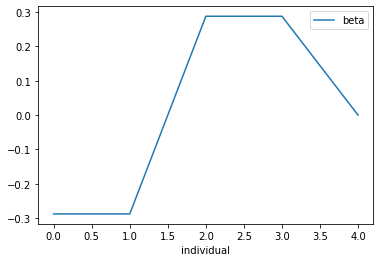

In [29]:
fig, ax = plt.subplots()
data.groupby('timescale').plot(x='individual', y='beta', ax=ax)
# data.plot(x='individual', y='beta')

### Functions for pipeline

In [51]:
def dc_feature(inf_pts, act_pts):
    """
    Calculates the change in direction towards a point of influence for collected data and generated data
    
    Inputs:
        inf_pts: 3D numpy array containing the xy coordinates for the point of influence in every frame (indvidual, frame, 2)
        act_pts: 3D numpy array with raw xy positions of animals in space with shape (individual, frame, 2)
    Outputs:
        act_dc: 2D numpy array containing the change in direction towards the point of influence for every individual in every frame
        alt_dcl: list of 2D numpy arrays containing the change in direction towards the point of influence for every individuals alternative steps
    """
    
    #generate change in direction from pt of influence for chosen and alternative steps
    act_dc = dir_change(inf_pts, act_pts)
    alt_sl = random_steps(act_pts)

    alt_dcl = []
    for i in range(len(alt_sl)):
        alt_dc = dir_change(inf_pts, act_pts, alt_sl[i], rand_step=True)
        alt_dcl.append(alt_dc)
        
    return act_dc, alt_dcl

In [109]:
def dfl(alt_l, chosen, alt_fl=False, chosen_fl=False):
    """
    Generates a dataframe containing all individuals and a list of data frames, one for each individual. Dfs can contain single or multiple features
    
    Inputs:
        alt_l: list consisting of 2d numpy arrays. len(list) = number of alternative steps generated
        chosen: 2d numpy array
        alt_fl: a list of lists consisting of 2d numpy arrays. len(alt_fl) = number of features. len(alt_fl[0]) = number of alternative steps generated
        chosen_fl: list consisting of 2d numpy arrays. len(list) = number of features
    Output:
        ind_dfl: list of dataframes, one for each individual with columns 'individual', 'feature', 'label', and 'frame'
        if alt_fl and chosen_fl==True:
            ind_dfl: a list of pandas dfs, one for each individual with columns 'individual', 'feature' * n, 'label', and 'frame'
    """
    
    if alt_fl & chosen_fl==True:
        df = mult_feat_df(alt_fl, chosen_fl)
        
    else:
        df = mclogit_df(alt_l, chosen)
    
    ind_dfl = ind_dfs(df, chosen.shape[0])
    
    return ind_dfl

In [88]:
def save(filename, t, drop_lst, ind_dfl):
    """
    Drops individuals with bad data and saves their dfs. Also returns a population df containing only the individuals with good data
    
    Inputs:
        filename: string
        t: int desigating the new timescale at witch the data is being analyzed
        drop_lst: list of individuals to be dropped from dataset
        ind_dfl: list of dataframes, one for each individual 
    Output:
        pop_df: dataframe consisting of all individuals in the dataset with good data (individuals with bad data has been dropped)
    """
    for i in range (len(ind_dfl)):
        ind_dfl[i].to_csv(r'/Users/taylorcarter/Desktop/' + filename + '_ind' + str(i) + 
                                          'df_t' + str(t) + '.csv', index = False, header=True)
    #drop individuals with 'bad data'
    for ind in drop_lst:
        os.remove(filename + '_ind' + str(ind) + 'df_t' + str(t) + '.csv')


    #drop 'bad data' from population df
    drop_lst1 = list.copy(drop_lst)
    for ind in range(len(drop_lst1)):
        if len(drop_lst1) > 1:
            if drop_lst1[ind] >= drop_lst1[1]:
                drop_lst1[ind] = drop_lst1[ind] - ind

        del ind_dfl[drop_lst1[ind]]
    pop_df = pd.concat(ind_dfl)

    pop_df.to_csv(r'/Users/taylorcarter/Desktop/' + filename + '_population_df_t' + 
                         str(t) + '.csv', index = False, header=True)
    return pop_df

In [107]:
def beta_df(act_pts, times, drop_lstl, filename):
    """
    Generates a df consisting of beta values for each individual, for each feature, at every time series
    
    Inputs:
        act_pts: 3D numpy array with raw xy positions of animals in space with shape (individual, frame, 2)
        times: list of time scale adjustments (ints)
        drop_lstl: list of lists containing individuals to drop for each time series in times
        filename: string, name of file from mclogit
    Output:
        beta_df: df consisting of beta values for each individual, for each feature, at every time series
    
    """
    
    ind_idl = []
    t_idl = []
    
    for t in range(len(times)):
        
        #create 'individual' and 'timescale' column
        ind_id = np.zeros((1, act_pts.shape[0]+1))
        t_id = np.zeros((1, act_pts.shape[0]+1))

        for i in range(ind_id.shape[1]):
            ind_id[:,i] = ind_id[:,i] + i
        #     ind_id[:,-1] = -1 #bad when plotting

        for i in range(t_id.shape[0]):
            t_id[i] = t_id[i] + times[t]

        #drop individual with 'bad data'
        ind_id = np.delete(ind_id, drop_lstl[t], axis=1)
        t_id = np.delete(t_id, drop_lstl[t], axis=1)

        ind_id = np.concatenate((ind_id), axis=0)
        t_id = np.concatenate((t_id), axis=0)

        ind_idl.append(ind_id)
        t_idl.append(t_id)
    
    ind_id = np.concatenate(ind_idl)
    t_id = np.concatenate(t_idl)
    
    #put all columns together in one dataframe
    beta_df = pd.read_csv(filename + "_output.csv")
    beta_df.insert(0, 'individual', ind_id, True)
    beta_df.insert(beta_df.shape[1], 'timescale', t_id, True)
    
    return beta_df

### Create and test social density fucntion
    - Fraction of all troop mates withing a 4.25m radius (1 for now) of poulation location (the group center will be the population location)

In [447]:
def cal_fraction(array1, array2, r, num_ind_drop=0):
    """
    Calcualtes fraction of individuals within a given radius of a focal individual
    
    Inputs:
        array1: 3D numpy array (ind, frame, xy)
        array2: 3D numpy array (ind, frame, xy). Focal indivdual
        num_ind_drop: number of individuals to drop from the data (problem with too many NaNs)
    Output:
        counts: 2D numpy array containing the fraction of individuals within the given radius of the focal individual. shape (ind, frame)
    
    """
    counts = np.zeros((array1.shape[0], array1.shape[1]))
    
    for ind in range(array1.shape[0]):
        loc = (array1[:,:,0] - array2[ind,:,0])**2 + (array1[:,:,1] - array2[ind,:,1])**2
        loc = np.where((loc<=r**2), 1, 0)
        loc[ind] = 0 #eliminating focal individual from count
        
        fraction = np.nansum(loc, axis=0)/((array1.shape[0]-1) - num_ind_drop)
        counts[ind] = fraction
    
    return counts

In [52]:
def sd_feature(alt_pts, act_pts, r, num_ind_drop=0):
    """
    Calculates fraction of all group mates within a given radius of a focal indivdiual and its alternative steps
    
    Inputs:
        alt_pts: list of 3D numpy arrays with new xy positions of animals in pts_act. alt_pts[0] = xy coordinates
                 of an alternative step for each individual
        act_pts: 3D numpy array with raw xy positions of animals in space with shape (individual, frame, 2)
        r: int, radius of circle of social influence
        numb_ind_drop: int (len(drop_lst)). number of individuals to drop from dataset (too many NaNs)
    Output:
        counts: 2D numpy array containing the fraction of individuals within the given radius of the focal individual. shape (ind, frame)
        alt_countsl: list of 2d numpy arrays containing the fraction of individuals within the given radius of a focal individuals alternative step.
                     shape (ind, frame)
    
    """
    counts = cal_fraction(act_pts, act_pts, r, num_ind_drop=0)    
    counts = counts[:,:-1] #need drop last frame to match len of direction change feature
    
    alt_countsl = []
    for step in range(len(alt_pts)):
        alt_counts = cal_fraction(act_pts, alt_pts[step], r, num_ind_drop=0)
        alt_counts = alt_counts[:, :-1] #need drop last frame to match len of direction change feature
        
        alt_countsl.append(alt_counts)
    
    return counts, alt_countsl

#### Test of sd_feature fucntion and cal_fraction funcitons

In [450]:
small_array = np.random.rand(4, 24, 2)
r = 3 #all individuals are within this radius because small_array is numbers btwn 0 and 1 => fraction should be 1
rsl = random_steps(small_array)
chosen_sd, alt_l_sd = sd_feature(rsl, small_array, r)

In [451]:
print(chosen_sd) #fraction of individuals in the circle
print(alt_l_sd)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.]]), array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [530]:
r = 10 #all individuals are within this radius because small_array is numbers btwn 0 and 1 => fraction should be 1
rsl = random_steps(positions[0])
chosen_sd, alt_l_sd = sd_feature(rsl, positions[0], r, num_ind_drop=2)

/opt/anaconda2/envs/mixed/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()


In [532]:
print(chosen_sd)
# print('space')
# print(alt_l_sd)

[[0.14285714 0.14285714 0.14285714 ... 0.07142857 0.07142857 0.07142857]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


### Create and test recently used space function
    - Number of other individuals (not including the focal individual) that have occupied a potential location within the past 4.5 min (4 frames for now)
        - Considered to occupy the location if within 1m of that location

In [555]:
def count_ind(array1, array2, r, time, double_count=True):
    """
    Calcualtes number of individuals that have occupied a potential location within the past time
    
    Inputs:
        time: int. How many frames to look back through
        array1: 3D numpy array (ind, frame, xy)
        array2: 3D numpy array (ind, frame, xy). Focal indivdual
    Output:
        counts: 2D numpy array containing the number of individuals that have occupied a potential location within the past time
        If double_count==False:
            counts: 2D numpy array containing the number of individuals that have occupied a potential location within the past time. Individuals will not
                    be double counted
    """

    counts = np.zeros((array1.shape[0], array1.shape[1]))
    
    #need to fill in with NaNs to keep indexing intact when making a df
    counts[:,0:time] = counts[:,0:time] * np.NaN

    for ind in range(array1.shape[0]):
        for f in range(array1.shape[1]-time):
            loc = (array1[:,f:time+f,0] - array2[ind,time+f,0])**2 + (array1[:,f:time+f,1] - array2[ind,time+f,1])**2
            loc = np.where((loc<=r**2), 1, 0)
            loc[ind] = 0 #eliminating focal individual from count
            
            if double_count==False:
                
                loc = np.any(loc, axis=1)
                count = np.sum(loc)
                
            else:
                count = np.nansum(loc)
            
            counts[ind,f+time] = count
                
    return counts

In [537]:
def ru_feature(alt_pts, act_pts, r, time, double_count=True):
    """
    Calculates number of individuals that have occupied a potential location within the past 4.5min for a focal indivdiual and its alternative steps
    
    Inputs:
        num: int. How many frames to look back through
        alt_pts: list of 3D numpy arrays with new xy positions of animals in pts_act. alt_pts[0] = xy coordinates
                 of an alternative step for each individual
        act_pts: 3D numpy array with raw xy positions of animals in space with shape (individual, frame, 2)
        r: int, radius of circle of social influence
    Output:
        counts: 2D numpy array containing the fraction of individuals within the given radius of the focal individual. shape (ind, frame)
        alt_countsl: list of 2d numpy arrays containing the fraction of individuals within the given radius of a focal individuals alternative step.
                     shape (ind, frame)
    
    """
    counts = count_ind(act_pts, act_pts, r, time, double_count)  
    counts = counts[:,:-1] #need drop last frame to match len of direction change feature
    
    alt_countsl = []
    for step in range(len(alt_pts)):
        alt_counts = count_ind(act_pts, alt_pts[step], r, time, double_count)
        alt_counts = alt_counts[:, :-1] #need drop last frame to match len of direction change feature
        
        alt_countsl.append(alt_counts)
    
    return counts, alt_countsl

#### Test of ru_feature fucntion and count_ind funcitons

In [560]:
small_array = np.random.rand(4, 24, 2)
t = 4
radius = 0.5 #all individuals are within this radius because small_array is numbers btwn 0 and 1
rsl = random_steps(small_array)
chosen_t, alt_l_t = ru_feature(rsl, small_array, radius, t, True) #allows individuals to be counted twice in every timeframe being analyzed; max of t * (small_array.shape[0]-1)
chosen_f, alt_l_f = ru_feature(rsl, small_array, radius, t, False) #does not allow individuals to be counted more than once in every timeframe being analyzed; small_array.shape[0]-1

In [561]:
print(chosen_t)
print(chosen_f)

[[nan nan nan nan  5.  3.  4.  6.  7.  3.  7.  9.  5.  4.  6.  3.  7.  6.
   7.  5.  6.  8.  8.]
 [nan nan nan nan  5. 10.  8.  5.  3.  2.  4. 10.  5.  9.  7.  4.  4.  9.
   2.  4.  4.  6.  3.]
 [nan nan nan nan  6.  9.  1.  8.  9.  3.  4.  6.  4.  3.  8.  5.  8.  7.
   5.  6.  6.  9.  3.]
 [nan nan nan nan  4.  5.  5.  7.  8.  7.  3.  2.  6.  4.  9.  9.  8.  8.
   5.  3.  8.  8.  8.]]
[[nan nan nan nan  3.  1.  2.  3.  3.  1.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.]
 [nan nan nan nan  3.  3.  3.  3.  3.  2.  2.  3.  3.  3.  3.  3.  3.  3.
   1.  2.  2.  3.  2.]
 [nan nan nan nan  3.  3.  1.  3.  3.  2.  2.  3.  2.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  1.]
 [nan nan nan nan  3.  3.  3.  3.  3.  3.  2.  1.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.]]


In [538]:
#has yet to run with all frames

t = 1800
radius = 100 #all individuals are within this radius because small_array is numbers btwn 0 and 1
rsl = random_steps(positions[0][:,:1802])
chosen_t, alt_l_t = ru_feature(rsl, positions[0][:,:1802], radius, t, True) #allows individuals to be counted twice in every timeframe being analyzed; max of t * (small_array.shape[0]-1)
chosen_f, alt_l_f = ru_feature(rsl, positions[0][:,:1802], radius, t, False) #does not allow individuals to be counted more than once in every timeframe being analyzed; small_array.shape[0]-1

/opt/anaconda2/envs/mixed/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less_equal


In [539]:
print(chosen_t)
print(chosen_f)

[[   nan    nan    nan ...    nan    nan 17400.]
 [   nan    nan    nan ...    nan    nan 17400.]
 [   nan    nan    nan ...    nan    nan 17400.]
 ...
 [   nan    nan    nan ...    nan    nan     0.]
 [   nan    nan    nan ...    nan    nan     0.]
 [   nan    nan    nan ...    nan    nan     0.]]
[[nan nan nan ... nan nan 11.]
 [nan nan nan ... nan nan 11.]
 [nan nan nan ... nan nan 11.]
 ...
 [nan nan nan ... nan nan  0.]
 [nan nan nan ... nan nan  0.]
 [nan nan nan ... nan nan  0.]]


In [549]:
import time

In [562]:
t = 300
frame = 500
rsl = random_steps(positions[0][:,:frame])
t0 = time.time()
chosen_t, alt_l_t = ru_feature(rsl, positions[0][:,:frame], radius, t, True)
t1 = time.time()
chosen_f, alt_l_f = ru_feature(rsl, positions[0][:,:frame], radius, t, False)
t2 = time.time()
print(t1-t0)
print(t2-t1)

/opt/anaconda2/envs/mixed/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less_equal


3.124190092086792
2.7985939979553223


### Pipeline with actual data

#### 1 - Generating data for direction change feature

In [540]:
#did for multiple times but individually
times = [30, 60, 90, 1800]
drop_lstl = []

for t in range(len(times)):
    #alter data time scale 
    time_adj, drop_lst = ts_adjust(positions[0], times[t])
    drop_lstl.append(drop_lst)
    
    #generate feature(s)
    _, act_center = group_center(time_adj)
    act_dc, alt_dcl = dc_feature(act_center, time_adj)
    
    #create dataframes for mclogit
    ind_dfl = dfl(alt_dcl, act_dc)
    
    #create population df and save ind as well as population dfs
    filename = 'dc_positions0'
    pop_df = save(filename, times[t], drop_lst, ind_dfl)

/opt/anaconda2/envs/mixed/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
/opt/anaconda2/envs/mixed/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


In [547]:
times = [30, 60, 90, 1800]
filename = 'dc_positions0'
df = beta_df(positions[0], times, drop_lstl, filename)
# df

timescale
30.0      AxesSubplot(0.125,0.125;0.775x0.755)
60.0      AxesSubplot(0.125,0.125;0.775x0.755)
90.0      AxesSubplot(0.125,0.125;0.775x0.755)
1800.0    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

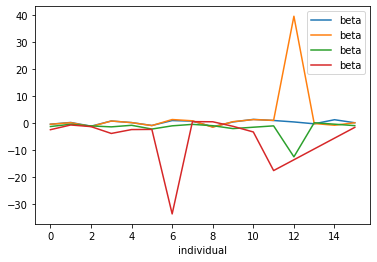

In [542]:
fig, ax = plt.subplots()
data.groupby('timescale').plot(x='individual', y='beta', ax=ax)

#### 2 - Generating data for social density feature

In [548]:
#did for multiple times but individually
times = [30, 60, 90, 1800]
drop_lstl = []
r = 1
for t in range(len(times)):
    #alter data time scale 
    time_adj, drop_lst = ts_adjust(positions[0], times[t])
    drop_lstl.append(drop_lst)
    
    #generate feature(s)
    rsl = random_steps(time_adj)
    chosen_sd, alt_l_sd = sd_feature(rsl, time_adj, r)

    #create dataframes for mclogit
    ind_dfl = dfl(alt_l_sd, chosen_sd)
    
    #create population df and save ind as well as population dfs
    filename = 'sd_positions0'
    pop_df = save(filename, times[t], drop_lst, ind_dfl)

/opt/anaconda2/envs/mixed/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()


In [545]:
times = [30, 60, 90, 1800]
filename = 'sd_positions0'
df = beta_df(positions[0], times, drop_lstl, filename)

ValueError: Length of values does not match length of index

#### 3 - Generating data for recently used space feature